<a href="https://colab.research.google.com/github/Santiago-Quinteros/Computational_Imaging_Heat_equation-TP/blob/main/Computational_Imaging_Heat_equation_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Practical session (graded session), Computational Imaging**

## Student names:
Santiago Quinteros,
Alvaro Scarramberg

Objective: implement and evaluate continuous (variational) and discrete (MRF) formulations for image denoising

# Part I: Heat equation
Derive and implement the diffusion equation associated with the minimization of the regularisation energy $\int_\Omega \|\nabla u(p)\|^2dp$.

Load an image using skimage module. Test images are available at: https://scikit-image.org/docs/dev/auto_examples/data/plot_general.html#sphx-glr-auto-examples-data-plot-general-py. You may also select your own custom images.

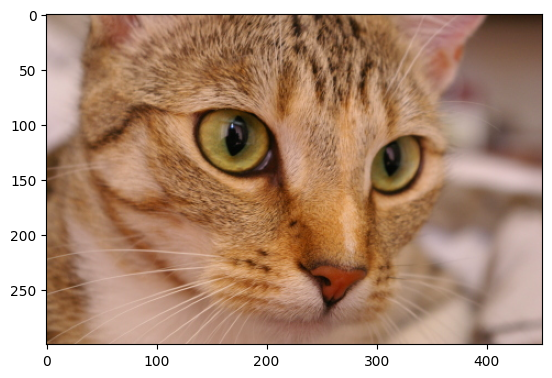

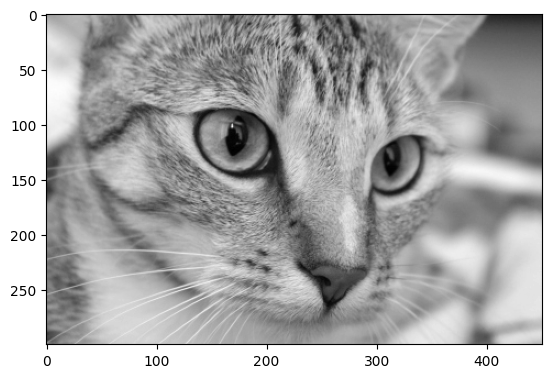

In [ ]:
## load an image
import skimage
import numpy as np
from skimage import filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

from skimage import data

u = getattr(data, 'cat')()
u = u / np.max(u)

u_gray = rgb2gray(u)

plt.imshow(u)
plt.show()

plt.imshow(u_gray, cmap='gray')
plt.show()



Apply a N-step diffusion process to the loaded image based on the heat equation
Code this N-step diffusion process as a callable function using as input parameters, the image u, the numer of iterations N and a scalar parameter $\lambda$

In [ ]:
def computeHeatDiffusion(u, N, lmbda):
    """
    Apply N-step diffusion process based on the heat equation.

    Parameters:
        u (numpy.ndarray): Input image.
        N (int): Number of iterations.
        lmbda (float): Scalar parameter.

    Returns:
        numpy.ndarray: Processed image after N iterations.
    """
    # Iterate N times
    uf = np.copy(u)
    for _ in range(N):
        # Compute Laplacian
        laplacian = filters.laplace(uf)

        # Update image using heat equation
        uf += lmbda * laplacian

    uf = (uf - np.min(uf))/(np.max(uf) - np.min(uf) )

    return uf


In [ ]:
def computeHeatDiffusionRGB(image, N, lmbda):
    """
    Apply N-step diffusion process based on the heat equation to RGB image.

    Parameters:
        image (numpy.ndarray): Input RGB image.
        N (int): Number of iterations.
        lmbda (float): Scalar parameter.

    Returns:
        numpy.ndarray: Processed RGB image after N iterations.
    """
    # Separate RGB channels
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    # Apply diffusion to each channel separately
    red_diffused = computeHeatDiffusion(red_channel, N, lmbda)
    green_diffused = computeHeatDiffusion(green_channel, N, lmbda)
    blue_diffused = computeHeatDiffusion(blue_channel, N, lmbda)

    # Combine diffused channels to form RGB image
    diffused_image = np.stack((red_diffused, green_diffused, blue_diffused), axis=-1)

    return diffused_image

Visualize the result of the diffusion on an image and highlight through an approriate visualization and/or evaluation metrics the quality of the output image.

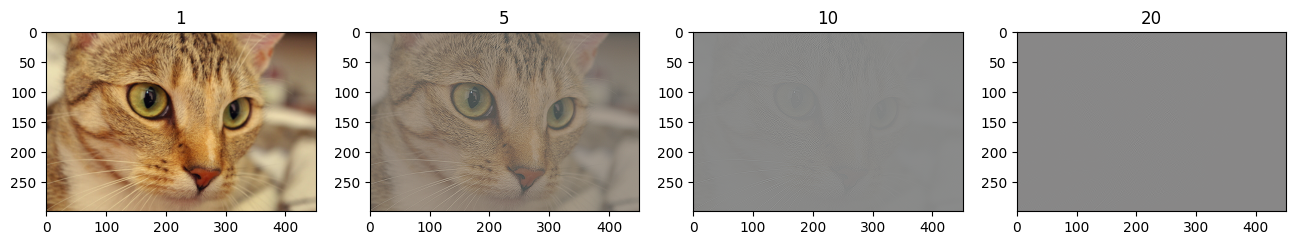

In [ ]:
lambda_ = 0.1

fig, axs = plt.subplots(1,4, figsize=(16,9))
N = [1, 5, 10, 20]
for k, ax in enumerate(fig.axes):
    # uf = computeHeatDiffusion(u_gray,N[k],lambda_)
    uf = computeHeatDiffusionRGB(u,N[k],lambda_)
    ax.imshow(uf)
    ax.set_title(f"{N[k]}")
    # ax.set_xticks([])
    # ax.set_yticks([])

plt.show()


# Part II: Heat equation for image denoising
Derive and implement the diffusion equation associated with image denoising according to the following cost function $\min_u \int_\Omega \| u(p)-v(p)\|^2dp+\alpha \int_\Omega \|\nabla u(p)\|^2dp$, where $v$ is a noisy image.

Load an image and generate a noisy image using an additive Gaussian noise. You can use function np.random.normal() to generate the noise.

In [ ]:
def add_noise(u, sigma):
    noisy_image = sigma * np.random.normal(size=u.shape) + u
    noisy_image = ( noisy_image - np.min(noisy_image) )/( np.max(noisy_image) - np.min(noisy_image) )
    return noisy_image

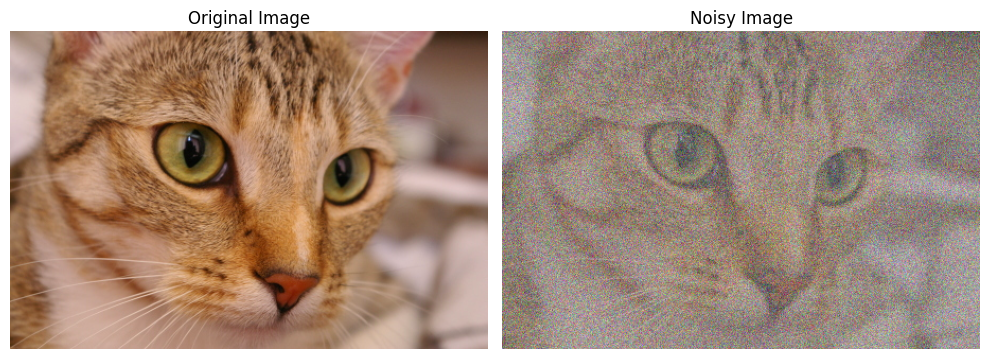

In [ ]:
noisy_image = add_noise(u, sigma=0.25)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the first subplot
axes[0].imshow(u)
axes[0].set_title('Original Image')

# Display the second image on the second subplot
axes[1].imshow(noisy_image)
axes[1].set_title('Noisy Image')

# Hide the axis labels
for ax in axes:
    ax.axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Implement a diffusion equation to solve the above minimization through a function denoisingHeatDiffusion(v,N,alpha) with v the noisy image, N the number of iterations of the diffusion, $\alpha$ the weighing factor of the regularization term and $\lambda$ the gradient step

In [ ]:
def denoisingHeatDiffusion(v,N,alpha,lambda_):
    u = v.copy()
    if N > 0:
        delta_t = 1 / N
    for n in range(N):
        uy, ux = np.gradient(u)
        _, uxx = np.gradient(ux)
        uyy, _ = np.gradient(uy)

        u = u + delta_t * lambda_ * (2*(v - u) + alpha*(uxx+uyy))


    return u

In [ ]:
def denoisingHeatDiffusionRGB(v,N,alpha,lmbda):
    # Separate RGB channels
    red_channel = v[:, :, 0]
    green_channel = v[:, :, 1]
    blue_channel = v[:, :, 2]

    # Apply diffusion to each channel separately
    red_diffused = denoisingHeatDiffusion(red_channel, N, alpha, lmbda)
    green_diffused = denoisingHeatDiffusion(green_channel, N, alpha, lmbda)
    blue_diffused = denoisingHeatDiffusion(blue_channel, N, alpha, lmbda)

    # Combine diffused channels to form RGB image
    u = np.stack((red_diffused, green_diffused, blue_diffused), axis=-1)

    u = (u - np.min(u))/(np.max(u) - np.min(u) )

    return u

Run denoising experiments and evaluate the quality of the denoising process w.r.t. the main parameters of the denoising scheme



In [ ]:
def MSE(u, v):
    return np.mean(np.square(u-v))

Illustrate through one or two examples the key properties of the diffusion  associated with this quadratic formulation

PSNR after 0 iterations: 16.150361606590927
PSNR after 5 iterations: 18.1355597304351
PSNR after 10 iterations: 18.120887682765897
PSNR after 15 iterations: 18.115801800596167
PSNR after 20 iterations: 18.11321761541567
Images made for:
	lambda: 0.5 
	alpha: 2.5


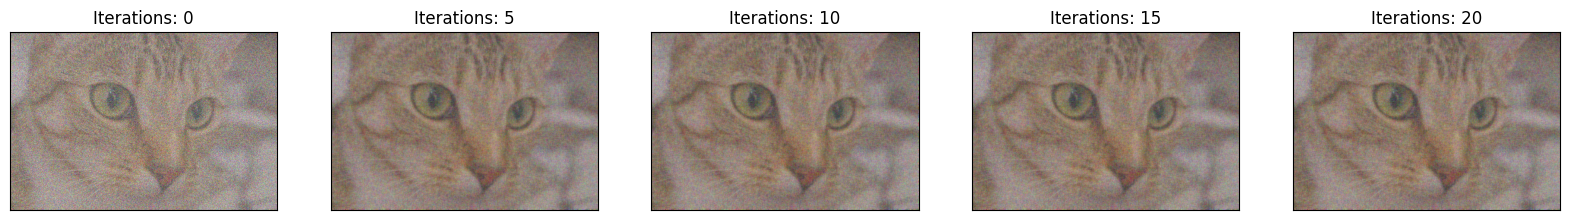

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr

lambda_ = 0.5
alpha = 2.5

noisy_image = add_noise(u, sigma=0.25)
# noisy_image = add_noise(u_gray, sigma=0.25)

fig, axs = plt.subplots(1,5, figsize=(20,10))
N = [0, 5, 10, 15, 20]
# print("Original PSNR:", psnr(u_gray, noisy_image))

for k, ax in enumerate(fig.axes):
    uf = denoisingHeatDiffusionRGB(noisy_image, N[k], alpha, lambda_)
    # uf = denoisingHeatDiffusion(noisy_image, N[k], alpha, lambda_)
    print("PSNR after " + str(N[k]) + " iterations:", psnr(u, uf))
    # print("\t PSNR after " + str(N[k]) + " iterations:", psnr(u_gray, uf))
    ax.imshow(uf, cmap='gray')
    ax.set_title("Iterations: " + str(N[k]))
    ax.set_xticks([])
    ax.set_yticks([])

print("Images made for:\n\tlambda:", str(lambda_), "\n\talpha:", str(alpha))
plt.show()

In [ ]:
lambda_range = [0.1,0.5,1.0,1.5,2]
alpha_range = [0.1,0.5,1.0,1.5,2,3,6,10]
N = list(range(10))

lambda_ = 0.1
PSNR_alpha = []
for k, alpha in enumerate(alpha_range):
    aux = []
    for n in N:
        uf = denoisingHeatDiffusionRGB(noisy_image,n,alpha, lambda_)
        aux.append(psnr(uf, u))
    PSNR_alpha.append(aux)

alpha = 0.5
PSNR_lambda = []
for k, lambda_ in enumerate(lambda_range):
    uf = denoisingHeatDiffusionRGB(noisy_image,N[k],alpha, lambda_)
    aux = []
    for n in N:
        uf = denoisingHeatDiffusionRGB(noisy_image,n,alpha, lambda_)
        aux.append(psnr(uf, u))
    PSNR_lambda.append(aux)

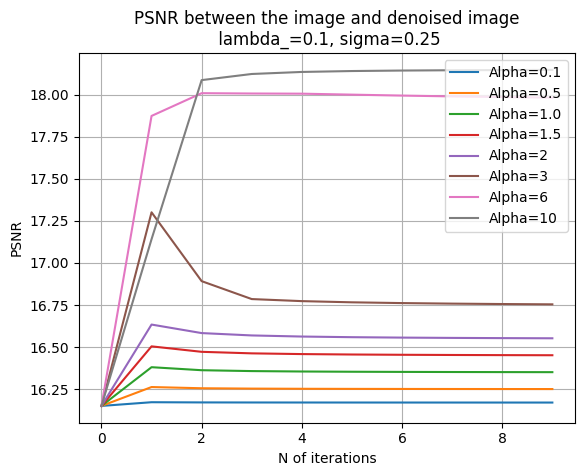

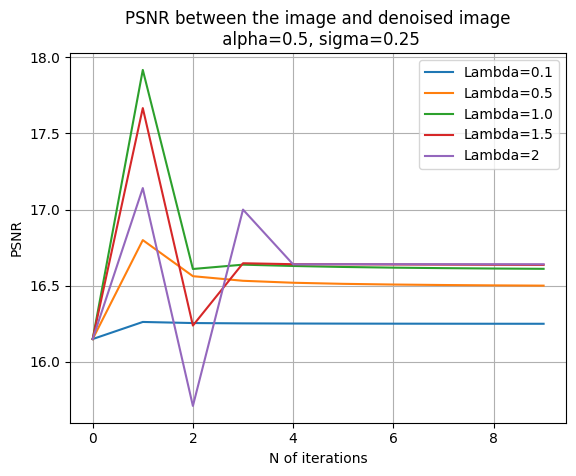

In [ ]:
plt.figure()
for a in range(len(PSNR_alpha)):
    plt.plot(N, PSNR_alpha[a])
plt.title("PSNR between the image and denoised image\n lambda_=0.1, sigma="+str(0.25))
plt.xlabel("N of iterations")
plt.ylabel("PSNR")
plt.legend(["Alpha="+str(a) for a in alpha_range], loc='upper right')
plt.grid()
plt.show()

plt.figure()
for a in range(len(PSNR_lambda)):
    plt.plot(N, PSNR_lambda[a])
plt.title("PSNR between the image and denoised image\n alpha=0.5, sigma="+str(0.25))
plt.xlabel("N of iterations")
plt.ylabel("PSNR")
plt.grid()
plt.legend(["Lambda="+str(a) for a in alpha_range], loc='upper right')
plt.show()

## Conclusion
The best results (highest PSNR) are found in the first iterations, then the diffusion is too high.

Augmenting Alfa has better results until it saturates.
An optimal Lambda can be found but it depends on the alfa chosen.

A balance can be made between the 2 parameters to find the best results for the image.

# Part III: TV regularization
Derive and implement the diffusion equation associated with the minimization of the regularisation energy $\int_\Omega \sqrt{\epsilon + \|\nabla u(p)\|^2}dp$. We recall that for an energy $\int_\Omega \rho( \|\nabla u(p)\|^2 )dp$ the associated diffusion equation is given by:
$$ \frac{\partial u}{\partial t}= div \left ( \rho'(\|\nabla u(p)\| )  \frac{\nabla u(p)}{\|\nabla u(p)\|} \right )$$
Compare the numerical schemes derived from (i) the discretized version of the analytical expression of the diffusion operator, and (ii) the discretized version of the divergence operator applied to $\rho'(\|\nabla u(p)\| )  \frac{\nabla u(p)}{\|\nabla u(p)\|}$.


We see that:
$$ \rho(t) = \sqrt{\epsilon+ t^2} \quad ⇒\quad  \frac{\partial \rho(t)}{ \partial t} =
\frac{t}{\sqrt{\epsilon+ t^2}} $$````

So we can write:

$$ \frac{\partial u}{\partial t}= div \left (
  \frac{\|\nabla u(p)\|}{\sqrt{\epsilon+ \|\nabla u(p)\|^2}}
  \frac{\nabla u(p)}{\|\nabla u(p)\|} \right ) =
  div \left (
  \frac{\nabla u(p)}{\sqrt{\epsilon+ \|\nabla u(p)\|^2}}\right )=
$$  
$$
  \frac{div(\nabla u(p))}{\sqrt{\epsilon+ \|\nabla u(p)\|^2}}+
  \nabla u(p)\nabla\left(\frac{1}{\sqrt{\epsilon+ \|\nabla u(p)\|^2}}\right)=
  \frac{\Delta u(p)}{\sqrt{\epsilon+ \|\nabla u(p)\|^2}}-
  \frac{\nabla u(p)\nabla(\|\nabla u(p)\|^2)}{2\left(\epsilon+ \|\nabla u(p)\|^2\right)^{3/2}}
  $$

$$ \Rightarrow \nabla u(p)\nabla(\|\nabla u(p)\|^2)= \nabla u(p)\nabla( u_x^2+ u_y^2) = \nabla u(p)2( u_{xx}+u_{yx}, u_{xy}+u_{yy}  ) =
2( u_x(u_{xx}+u_{yx}) + u_y(u_{xy}+u_{yy}) ) $$

Finally we get:

$$
\frac{\Delta u(p)}{\sqrt{\epsilon+ \|\nabla u(p)\|^2}}-
\frac{1}{\left(\epsilon+ \|\nabla u(p)\|^2\right)^{3/2}}
\left[ \frac{\partial u}{ \partial x}\left( \frac{\partial u^2}{ \partial x^2}+
\frac{\partial u^2}{ \partial y \partial x}\right)+
 \frac{\partial u}{ \partial y}\left( \frac{\partial u^2}{ \partial x\partial y}+\frac{\partial u^2}{  \partial y^2}\right)\right]
$$


In [ ]:
def TVregularization(u, N, lambda_, epsilon):

    g = u.copy()
    for n in range(N):
        gy, gx = np.gradient(g)
        gxy, gxx = np.gradient(gx)
        gyy, gyx = np.gradient(gy)

        aux_1 = epsilon + gy**2 + gx**2
        term_1 = (gxx**2 + gyy**2)/np.sqrt(aux_1)
        term_2 = (gx*(gxx + gyx)+gy*(gxy + gyy) )/((aux_1)**(3/2))

        g = g + lambda_ * (term_1 - term_2)

        g = (g - np.min(g))/(np.max(g) - np.min(g) )

    return g


Run regularization experiments and evaluate the quality of the denoising process w.r.t. the main parameters of the regularization scheme

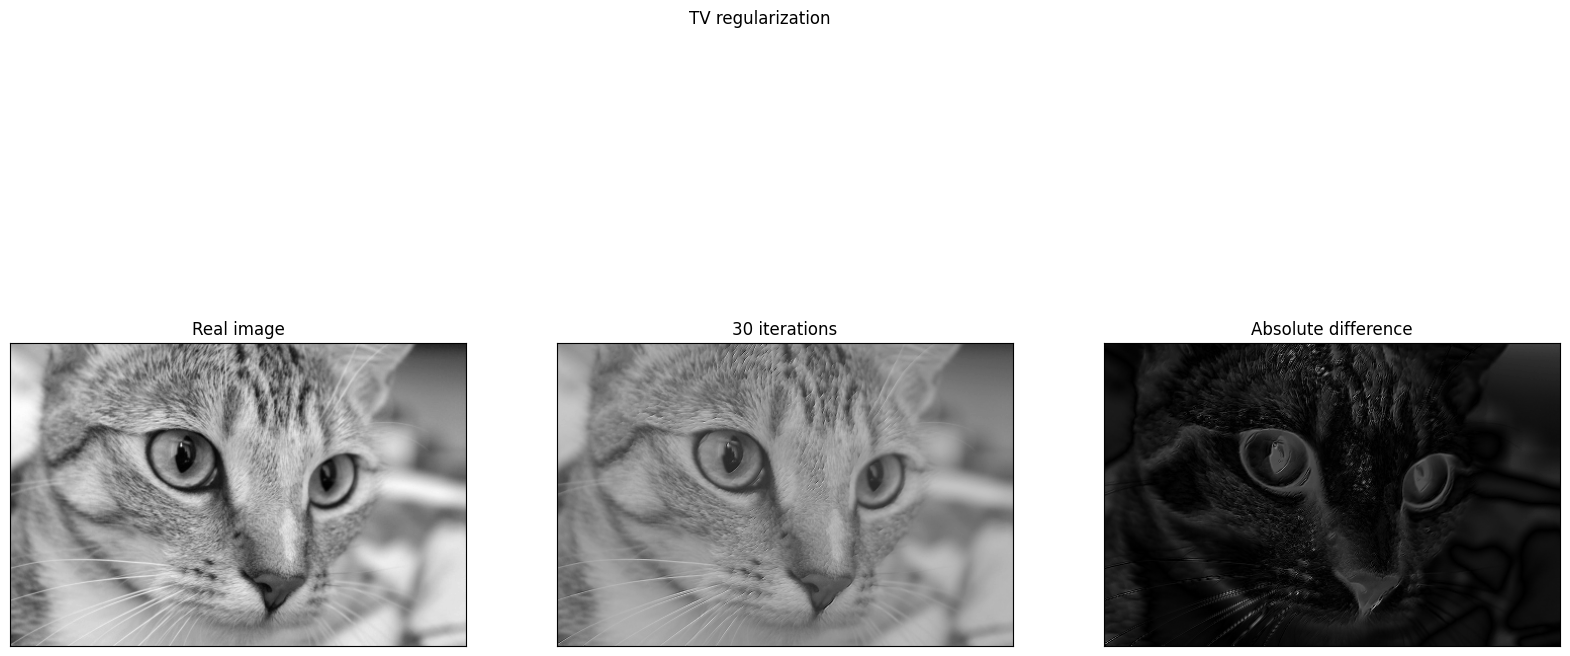

In [ ]:
lambda_ = 0.01
epsilon = 0.1
N = 30

fig, axs = plt.subplots(1,3, figsize=(20,10))
axs = fig.axes

axs[0].imshow(u_gray, cmap='gray')
axs[0].set_title("Real image")
uf = TVregularization(u_gray,N,lambda_, epsilon)
axs[1].imshow(uf, cmap='gray')
axs[1].set_title("{:d} iterations".format(N))
axs[2].imshow(np.abs(u_gray-uf), cmap='gray')
axs[2].set_title("Absolute difference")

for ax in fig.axes:
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle("TV regularization")
plt.show()



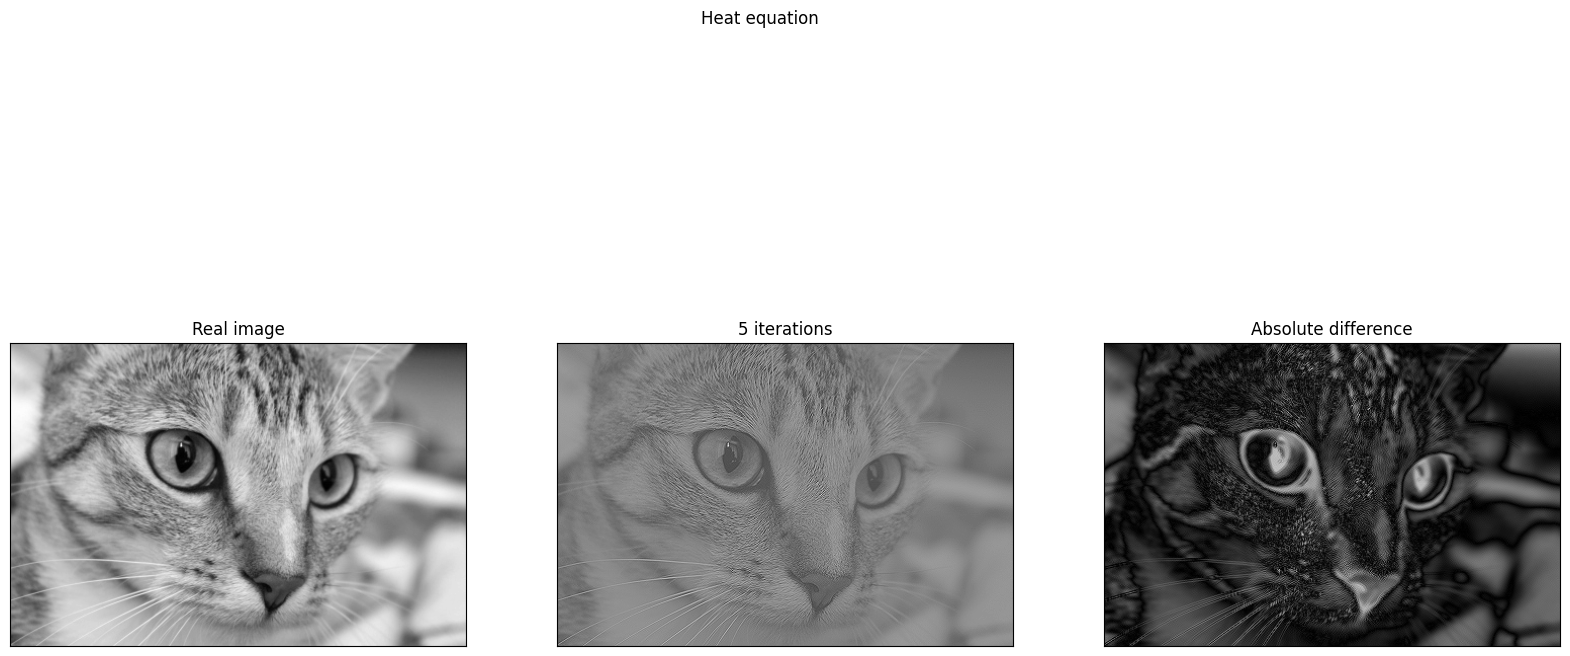

In [ ]:
lambda_ = 0.1
N = 5

fig, axs = plt.subplots(1,3, figsize=(20,10))
axs = fig.axes

axs[0].imshow(u_gray, cmap='gray')
axs[0].set_title("Real image")
uf = computeHeatDiffusion(u_gray,N,lambda_)
axs[1].imshow(uf, cmap='gray')
axs[1].set_title("{:d} iterations".format(N))
axs[2].imshow(np.abs(u_gray-uf), cmap='gray')
axs[2].set_title("Absolute difference")

for ax in fig.axes:
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle("Heat equation")
plt.show()


Illustrate through one or two examples the key properties of the diffusion  associated with this TV formulation

## Answer:
This image shows how the TV regularization has less difference in the borders. Thus, showing how it preserves edges better than simply using the heat equation (isotropic difussion).

This is because TV regularization is a type of  anisotropic difussion. The changes in intensity are concentrated along edges, allowing for sharp boundaries.

# Part IV: TV denoising
Implement and benchmark TV denoising schemes, including a comparison to the Laplacian diffusion process.

In [ ]:
def TVdenoising(v, N, lambda_, alpha, epsilon):

    g = v.copy()
    if N > 0:
        delta_t = 1 / N
    for n in range(N):
        gy, gx = np.gradient(g)
        aux_1 = epsilon + gy**2 + gx**2

        _, gxx = np.gradient( gx / np.sqrt(aux_1))
        gyy, _ = np.gradient( gy / np.sqrt(aux_1))

        g = g - delta_t * lambda_ * ( 2 * (g-v) - alpha * (gxx + gyy))
        g = (g - np.min(g))/(np.max(g) - np.min(g) )

    return g

Illustrate through one or two examples the key properties of the diffusion  associated with the TV denoising

PSNR after 0 iterations: 17.4934992914661
PSNR after 2 iterations: 13.650384273057643
PSNR after 5 iterations: 19.540611452790397
PSNR after 10 iterations: 21.95407788646927
PSNR after 20 iterations: 22.98169980996746
Images made for:
	lambda: 0.5 
	alpha: 1


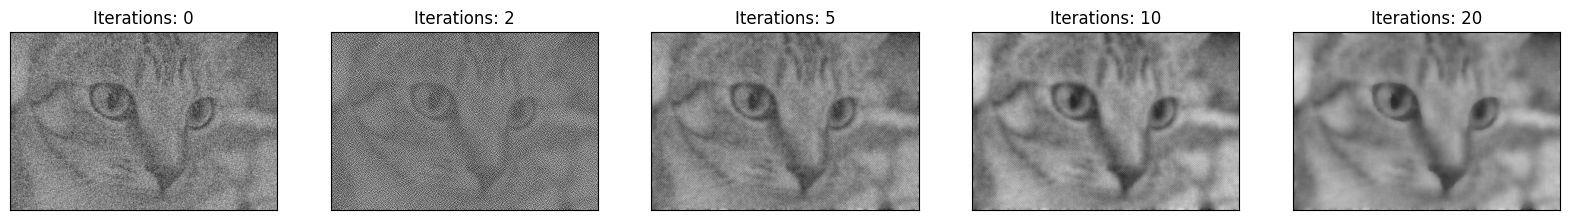

In [ ]:
lambda_ = 0.5
epsilon = 0.0001
alpha = 1

noisy_image = add_noise(u_gray, sigma=0.25)

fig, axs = plt.subplots(1,5, figsize=(20,10))
N = [0,2, 5, 10, 20, 30]

for k, ax in enumerate(fig.axes):
    uf = TVdenoising(noisy_image, N[k], lambda_, alpha, epsilon)
    print("PSNR after " + str(N[k]) + " iterations:", psnr(u_gray, uf))
    ax.imshow(uf, cmap='gray')
    ax.set_title("Iterations: " + str(N[k]))
    ax.set_xticks([])
    ax.set_yticks([])

print("Images made for:\n\tlambda:", str(lambda_), "\n\talpha:", str(alpha))
plt.show()

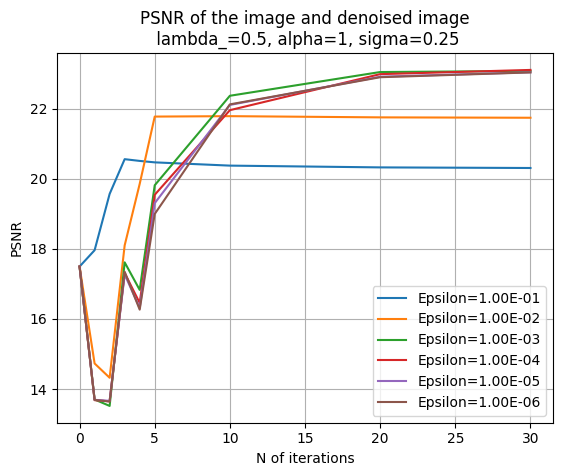

In [ ]:
epsilon_range = [0.1,0.01,0.001,0.0001,0.00001,0.000001]
N = [0, 1,2,3,4, 5, 10, 20, 30]

lambda_ = 0.5
alpha = 1

PSNR_epsilon = []
for k, epsilon in enumerate(epsilon_range):
    aux = []
    for n in N:
        uf = TVdenoising(noisy_image,n,lambda_, alpha, epsilon)
        aux.append(psnr(uf, u_gray))
    PSNR_epsilon.append(aux)

plt.figure()
for a in range(len(PSNR_epsilon)):
    plt.plot(N, PSNR_epsilon[a])
plt.title("PSNR of the image and denoised image\n lambda_=0.5, alpha=1, sigma="+str(0.25))
plt.xlabel("N of iterations")
plt.ylabel("PSNR")
plt.legend(["Epsilon={:7.2E}".format(a) for a in epsilon_range])
plt.grid()
plt.show()



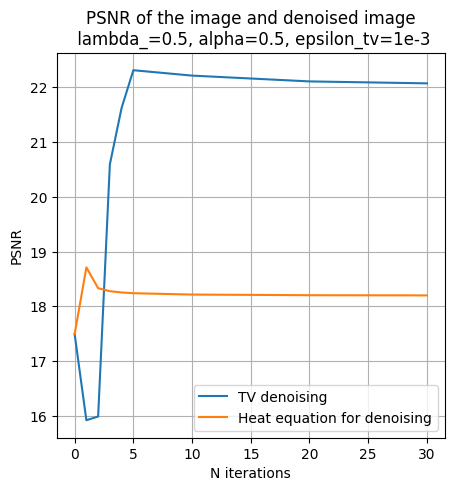

In [ ]:
lambda_=0.5
alpha=0.5
epsilon=1e-3

N = [0, 1,2,3,4, 5, 10, 20, 30]
sigma=0.25

PSNR_tv = []
PSNR_diff = []
aux_tv = []
aux_diff = []
for n in N:
    uf = TVdenoising(noisy_image,n,lambda_, alpha, epsilon)
    aux_tv.append(psnr(uf, u_gray))
    uf = denoisingHeatDiffusion(noisy_image,n,alpha, lambda_)
    aux_diff.append(psnr(uf, u_gray))
PSNR_tv.append(aux_tv)
PSNR_diff.append(aux_diff)

plt.figure(figsize=(5,5))
legend_ = ["TV denoising","Heat equation for denoising"]
plt.plot(N, PSNR_tv[0])
plt.plot(N, PSNR_diff[0])
plt.title("PSNR of the image and denoised image\n lambda_=0.5, alpha=0.5, epsilon_tv=1e-3")
plt.xlabel("N iterations")
plt.ylabel("PSNR")
plt.legend(legend_)
plt.grid()
plt.show()

## Answer
The PSNR of TV denoising is greater than the Heat equation for image denoising one.

In the first iterations we don't have desirable results, but after 5 iterations, the PSNR keeps increasing with the iterations

An epsilon in the order of 10^-3 showed the best results for this particular image.




# Part V: Perona-Malik diffusion (Bonus)
Implement and benchmark diffusion schemes defined as:
$$ \frac{\partial u}{\partial t}= div \left ( c(\|\nabla u(p)\| )  \nabla u(p) \right )$$
with different choices for function $c()$: $c(x)=1-exp(-x^2/K^2)$, $c(x)=\left [1+x^2/K^2\right]^{-1/2}$, $c(x)=\left [1+x^2/K^2\right]^{-1}$.

# Part VI: MRF-based image denoising
This section aims to implement and test Markov Random Field (MRF) algorithms for image denoising. Based on discretized version of variational energy:
$$ \int_\Omega \| u(p)-v(p)\|^2dp+\alpha \int_\Omega \|\nabla u(p)\|^2dp$$,
derive the observation lieklihood model $P(V|U)$ and the Markovian prior $P(U)$ of the associated MRF formulation.
Derive an iterative denoising algorithm based on the maximization of the following posterior likelihood: $$P(U_p|V,U_q, \ q \neq p )$$
Implement this algorithm and compare to the Laplacian diffusion process.

To derive the algorithm we begin with the discrete cost from the discretized variational energy.

$$ J(u) = \frac{1}{2} \sum_{i,j} (u_{i,j} - v_{i,j})^2 + \frac{\alpha}{2} \sum_{i,j} (\nabla u_{i,j})^2  $$

From here we will work on a per pixel basis, which means that the algorithm will iteratively find the $u_{i,j}$ which minimizes J(u) at each pixel. Thus at pixel i,j we want the cost as a function of $u_{i,j}$ only to minimize w.r.t $u_{i,j}$.

$$J(u_{i,j}) = \frac{1}{2} (u_{i,j} - v_{i,j})^2 + \frac{\alpha}{2} (\nabla u_{i,j})^2 + F(u)$$

F(u) is not a function of $u_{i,j}$, so we get the expression for the minimizing $u_{i,j}$:

$$\hat{u}{i,j} = argmin_u J(u{i,j})$$
$$\hat{u}{i,j} = argmin_u \frac{1}{2} (u{i,j} - v_{i,j})^2 + \frac{\alpha}{2} (\nabla u_{i,j})^2 + F(u)$$
$$\hat{u}{i,j} = argmin_u \frac{1}{2} (u{i,j} - v_{i,j})^2 + \frac{\alpha}{2} (\nabla u_{i,j})^2 $$

We can differentiate this expression to find $\hat{u}_{i,j}$. By using an approximation of the laplacian as a linear function of
${u}{i,j}$ in a finite neighborhood of ${u}{i,j}$ named $V$.

$$ 0 = u_{i,j} -  {v}{i,j} + \alpha \Delta u{i,j}$$

Thus we get the iterations:

$$ u^{k+1} = u^{k} - \lambda (u^{k} - v - \alpha \Delta u^{k})$$

Notably this can be done in the whole image instead of per pixel, which makes the computations much faster.

In [ ]:
from scipy.ndimage.filters import laplace

def MRFbasedDenoising(v, N, lambda_,alpha):
  u=v.copy()

  for i in range(N):
    u_laplace=laplace(u)
    u_new=u-lambda_*(u-v-alpha*u_laplace)
  u_new=(u_new - np.min(u_new))/(np.max(u_new) - np.min(u_new) )
  return u_new


<ipython-input-36-1e84743d7b5f>:1: DeprecationWarning: Please use `laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import laplace


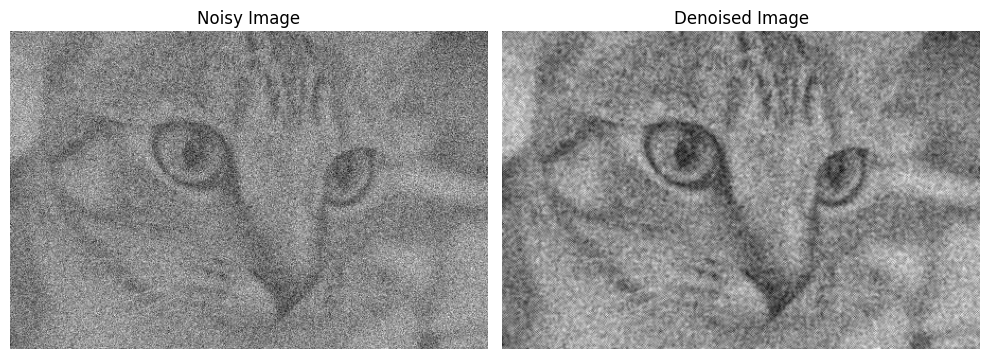

In [ ]:
lambda_ = 0.5
N=20
alpha = 0.5

denoised=MRFbasedDenoising(noisy_image, N, lambda_,alpha)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the first subplot
axes[0].imshow(noisy_image,cmap="gray")
axes[0].set_title('Noisy Image')

# Display the second image on the second subplot
axes[1].imshow(denoised,cmap="gray")
axes[1].set_title('Denoised Image')

# Hide the axis labels
for ax in axes:
    ax.axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()





Bonus: Using a m-estimator instead of the quadratic prior (cf. https://hal.inria.fr/inria-00350297/document) and an reweigthed iterative least-square algorithm, implement a generalization of the above MRF formulation which accounts for a more appropriate prior than a Gaussian prior.



```
`# This is formatted as code`
```

# Part VII: Variational minimization using autograd tools in pytorch
Link to autograd tutorial: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

In [ ]:
## implement the variational cost as a loss function using pytorch structures (eg, tensors)

import torch

def variational_cost(u_tensor, v_tensor, alpha):

    sobel_x = torch.Tensor(np.array([1,0,-1,2,0,-2,1,0,-1]).reshape(3,3))
    sobel_y = torch.Tensor(np.array([1,2,1,0,0,0,-1,-2,-1]).reshape(3,3))

    sobel_x = sobel_x.view(1,1,3,3)
    sobel_y = sobel_y.view(1,1,3,3)

    grad_x  = torch.nn.functional.conv2d(u_tensor, sobel_x.type(torch.DoubleTensor))
    grad_y  = torch.nn.functional.conv2d(u_tensor, sobel_y.type(torch.DoubleTensor))

    grad_1 = torch.pow(grad_x,2) + torch.pow(grad_y,2)
    grad_2 = torch.square(u_tensor-v_tensor)

    var_cost = grad_1.sum()+alpha*grad_2.sum()

    return var_cost

In [ ]:
def gradient_descent(u,v, N=N, alpha=alpha, lambda_=lambda_):

    uf = v.copy()
    delta = 1/N
    loss = []
    psnr_l = []

    v_tensor = torch.from_numpy(v)

    # Perform the gradient descent optimization
    for i in range(N):
        uf = torch.from_numpy(uf)
        uf = uf.view(1, 1, v.shape[0], v.shape[1]).requires_grad_(True)

        cost = variational_cost(uf,v_tensor, alpha)
        cost.backward()
        grad = uf.grad
        grad = grad.view(v.shape[0],v.shape[1])

        loss.append(cost.item())

        uf = uf.view(v.shape[0], v.shape[1]).detach().numpy()
        grad = grad.detach().numpy()
        uf = uf - delta * lambda_ * (2 * (uf-v) + alpha * grad)

        psnr_l.append(psnr(u,uf))

    return uf, loss, psnr_l

PSNR Autograd calculation:  19.152146782987284


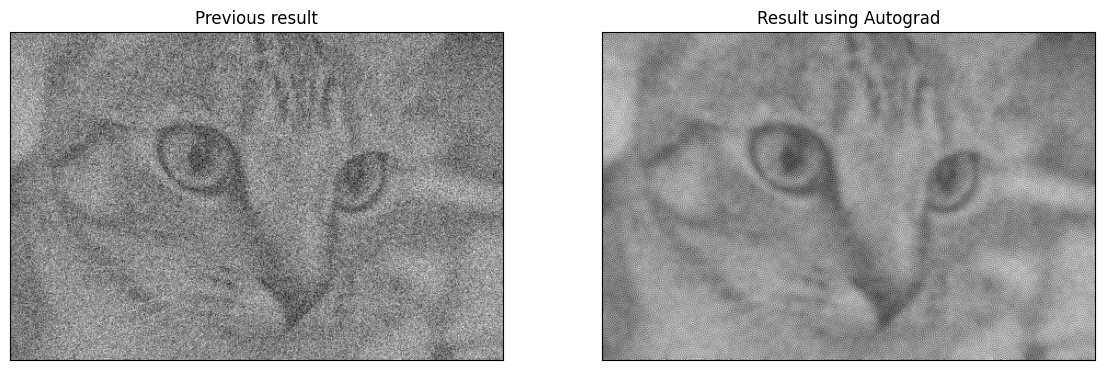

In [ ]:
## Check the difference between the gradient computed using autograd vs. the gradient derived analytically
n_iter = 10
alpha = 0.1
lambda_ = 0.4

v_analytic           = denoisingHeatDiffusion(noisy_image,n_iter,alpha,lambda_)
v_autograd,loss,psnr_l = gradient_descent(u_gray,noisy_image,n_iter,alpha,lambda_)

v_autograd = np.clip(v_autograd, 0,1)

print("PSNR Autograd calculation: ", psnr_l[-1])

fig, axs = plt.subplots(1,2, figsize=(14,8))
axs[0].imshow(v_analytic, cmap='gray')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Previous result")
axs[1].imshow(v_autograd, cmap='gray')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Result using Autograd")
plt.show()